In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping

# Thông số
root_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed/"
paths = [
    os.path.join(root_dir, "im_Dyskeratotic", "im_Dyskeratotic", "CROPPED"),
    os.path.join(root_dir, "im_Koilocytotic", "im_Koilocytotic", "CROPPED"),
    os.path.join(root_dir, "im_Metaplastic", "im_Metaplastic", "CROPPED"),
    os.path.join(root_dir, "im_Parabasal", "im_Parabasal", "CROPPED"),
    os.path.join(root_dir, "im_Superficial-Intermediate", "im_Superficial-Intermediate", "CROPPED")
]

height, width, channels = 224,224, 3
num_classes = len(paths)
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

# Load ảnh + nhãn
def load_images_from_paths(paths, img_size=(height, width)):
    images = []
    labels = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    for idx, p in enumerate(paths):
        if not os.path.exists(p):
            print(f"Warning: path not found {p}")
            continue
        for file in os.listdir(p):
            if not file.lower().endswith(valid_extensions):
                continue
            try:
                img_path = os.path.join(p, file)
                img = Image.open(img_path).convert('RGB').resize(img_size)
                img = np.array(img).astype(np.float32) / 255.0
                if img.shape != (height, width, channels):
                    continue
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Failed loading {file}: {e}")
                continue
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

X, y = load_images_from_paths(paths)
y = to_categorical(y, num_classes)

# Chia train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation dùng tf.data pipeline
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1000).map(augment, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)

# Model base DenseNet121
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(height, width, channels))
base_model.trainable = False

# Xây dựng model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=200,
                    callbacks=[early_stop])


29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/200
51/51 [==============================] - 32s 337ms/step - loss: 1.2521 - accuracy: 0.4946 - val_loss: 0.8767 - val_accuracy: 0.7420
Epoch 2/200
51/51 [==============================] - 12s 240ms/step - loss: 0.8017 - accuracy: 0.7218 - val_loss: 0.6386 - val_accuracy: 0.8000
Epoch 3/200
51/51 [==============================] - 12s 245ms/step - loss: 0.6317 - accuracy: 0.7901 - val_loss: 0.5354 - val_accuracy: 0.8259
Epoch 4/200
51/51 [==============================] - 13s 251ms/step - loss: 0.5368 - accuracy: 0.8203 - val_loss: 0.4737 - val_accuracy: 0.8481
Epoch 5/200
51/51 [==============================] - 13s 254ms/step - loss: 0.4737 - accuracy: 0.8450 - val_loss: 0.4372 - val_accuracy: 0.8593
Epoch 6/200
51/51 [==============================] - 13s 261ms/step - loss: 0.4286 - accuracy: 0.8533 - val_loss: 0.4047 - val_accuracy: 0.8667
Epoch 7/200
51/51 [==============================] - 14s 267ms/step - l

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


# Dự đoán trên tập kiểm tra
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Tính toán và in ra recall, f1-score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy on test set: {accuracy:.6%}")
report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(num_classes)])
print("Classification Report:")
print(report)


Accuracy on test set: 93.086420%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.97      0.95       179
     Class 1       0.87      0.87      0.87       164
     Class 2       0.91      0.90      0.90       173
     Class 3       0.97      0.96      0.96       139
     Class 4       0.97      0.97      0.97       155

    accuracy                           0.93       810
   macro avg       0.93      0.93      0.93       810
weighted avg       0.93      0.93      0.93       810



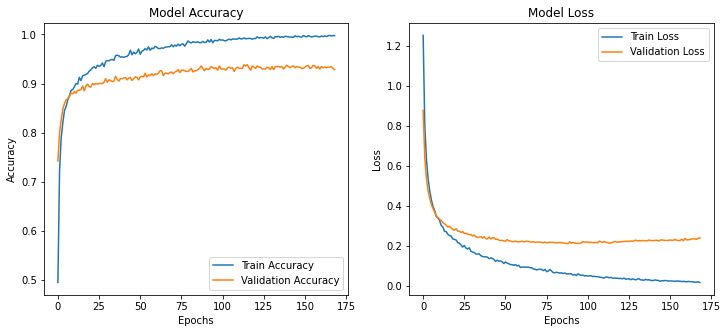

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# --- Visualize Training History ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()



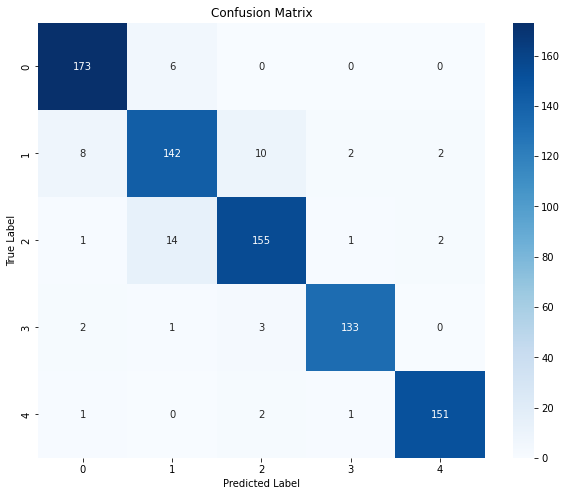

In [11]:
# --- Confusion Matrix ---
# Convert predictions to integer class labels
y_test_int = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_int, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


10 test predictions vs actual labels:
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 4, Actual: 4
Prediction: 4, Actual: 4
Prediction: 3, Actual: 3
Prediction: 4, Actual: 4
Prediction: 2, Actual: 2
Prediction: 2, Actual: 2
Prediction: 3, Actual: 3
Prediction: 2, Actual: 1


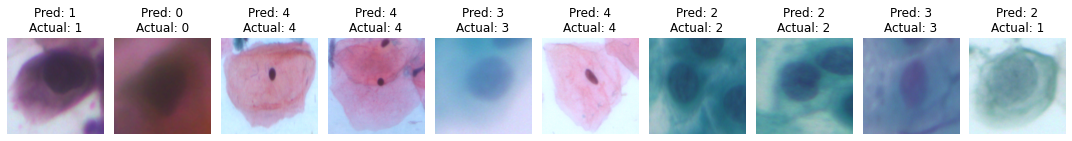

In [12]:
# --- Display Predictions vs Actual Labels ---
print("10 test predictions vs actual labels:")
for i in range(10):
    print(f"Prediction: {y_test_pred[i]}, Actual: {y_test_int[i]}")

# --- Display Images with Predictions ---
def display_images_with_predictions(X_test, y_test_pred, y_test_int, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_test[i])
        plt.title(f"Pred: {y_test_pred[i]}\nActual: {y_test_int[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_images_with_predictions(X_test, y_test_pred, y_test_int, num_images=10)
